In [27]:
import pandas as pd
import numpy as np
import nltk
#nltk.download()
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
## read the training data into a pandas dataframe
df = pd.read_csv('fake-news/train.csv')

In [5]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [32]:
## check for missing values
df.isna().sum().sum()
# delete rows with missing values
df = df.dropna()
# print new shape
print(df.shape)
# reset index post missing values deletion
df.reset_index(inplace=True)
df.head()

(18285, 6)


,level_0,index,id,title,author,text,label
0,0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [34]:
## create independent and dependent features 
# using the text data field as independent feature
messages = df['text']
y = df.iloc[:,-1]

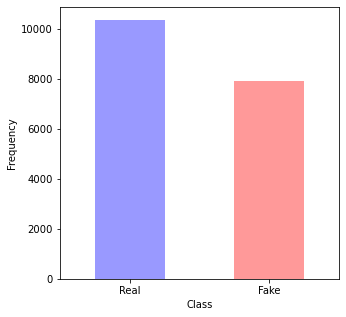

In [35]:
## check for class imbalance
count_classes = pd.value_counts(y, sort=True)
LABELS = ['Real', 'Fake']
plt.figure(figsize=(5,5))
count_classes.plot(kind='bar', rot=0, color=['blue', 'red'], alpha=0.4)
plt.xticks(range(2), LABELS)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [ ]:
count_classes[1]

In [ ]:
## text cleaning and preprocessing
# create a PorterStemmer object
sm = PorterStemmer()
corpus = []
for i in range(len(messages)):
    # remove characters or numbers apart from alphabets
    clean = re.sub('[^a-zA-Z]', ' ', messages[i])
    # put everything in lowercase
    clean = clean.lower()
    # split the sentences to a list of words to apply stemming/lemmatization
    clean = clean.split()
    # apply stemming
    clean = [sm.stem(word) for word in clean if not word in stopwords.words('english')]
    # join the words again to form a string
    clean = ' '.join(clean)
    # append to list
    corpus.append(clean)

In [ ]:
corpus

In [ ]:
## create a bag of words model
cv = CountVectorizer(max_features=5000)
X = cv.fit_transform(corpus).toarray()

In [ ]:
## perform a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
## fit a Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.pred(X_test)

In [ ]:
## evaluate model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Naive Bayes Classifier using Bag of Words model: ", accuracy)

In [ ]:
## evaluate using confusion matrix
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# convert to numpy matrix
val = np.conmat(cm)
# class labels (1: FAKE, 0: REAL)
classes = ['FAKE', 'REAL']
# create a dataframe from the 
df_cm